### Assets

In [2]:
from pydantic import BaseModel, Field
import openai
from openai import OpenAI
import json
from dotenv import load_dotenv
import unicodedata
load_dotenv()
import base64

client = OpenAI()

class IdeaModel(BaseModel):
    idea: str
    reasoning: str

class AbstractModel(BaseModel):
    abstract_idea: IdeaModel

class EventModel(BaseModel):
    value: str
    reasoning: str

class EventInformationModel(BaseModel):
    event: EventModel
    background : EventModel

class AttributeModel(BaseModel):
    attribute: str
    value: str

class EntityModel(BaseModel):
    entity: str
    attributes: list[AttributeModel]

class RelationshipModel(BaseModel):
    relationship: str
    reasoning: str

class GeoSpatialModel(BaseModel):
    country: str
    state_or_province: str
    city: str
    reasoning: str

class TemporalModel(BaseModel):
    century: str
    decade: str
    year: str
    month: str
    day: str
    reasoning: str

class CompleteModel(BaseModel):
    event_information: EventInformationModel
    geospatial_information: GeoSpatialModel
    temporal_information: TemporalModel

class PromptModel(BaseModel):
    prompt: str
    reasoning: str

class PromptsModel(BaseModel):
    global_event_specialist: PromptModel
    temporal_specialist: PromptModel
    spatial_specialist: PromptModel

class SceneGraphModel(BaseModel):
    entities: list[EntityModel]
    relationships: list[RelationshipModel]

structures = {
    "complete_model" :{
        "name": "complete_information",
        "description": "Represents the detailed event information including geospatial and temporal data.",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "event_information": {
                    "type": "object",
                    "description": "Information about the event and its background.",
                    "properties": {
                        "event": {
                            "type": "object",
                            "description": "Details about the event.",
                            "properties": {
                                "value": { "type": "string", "description": "The main event description." },
                                "reasoning": { "type": "string", "description": "Reasoning behind identifying this event." }
                            },
                            "required": ["value", "reasoning"],
                            "additionalProperties": False,
                        },
                        "background": {
                            "type": "object",
                            "description": "Contextual background related to the event.",
                            "properties": {
                                "value": { "type": "string", "description": "Background information related to the event." },
                                "reasoning": { "type": "string", "description": "Explanation of the background's relevance." }
                            },
                            "required": ["value", "reasoning"],
                            "additionalProperties": False,
                        }
                    },
                    "required": ["event", "background"],
                    "additionalProperties": False,
                },
                "geospatial_information": {
                    "type": "object",
                    "description": "Geospatial details of where the event took place.",
                    "properties": {
                        "country": { "type": "string", "description": "The country where the event occurred." },
                        "state_or_province": { "type": "string", "description": "The state or province where the event occurred." },
                        "city": { "type": "string", "description": "The city where the event occurred." },
                        "reasoning": { "type": "string", "description": "Justification for the given location details." }
                    },
                    "required": ["country", "state_or_province", "city", "reasoning"],
                    "additionalProperties": False,
                },
                "temporal_information": {
                    "type": "object",
                    "description": "Temporal details of when the event took place.",
                    "properties": {
                        "century": { "type": "string", "description": "The century in which the event occurred." },
                        "decade": { "type": "string", "description": "The decade in which the event occurred." },
                        "year": { "type": "string", "description": "The year in which the event occurred." },
                        "month": { "type": "string", "description": "The month in which the event occurred." },
                        "day": { "type": "string", "description": "The day on which the event occurred." },
                        "reasoning": { "type": "string", "description": "Justification for the provided temporal details." }
                    },
                    "required": ["century", "decade", "year", "month", "day", "reasoning"],
                    "additionalProperties": False,
                }
            },
            "additionalProperties": False,
            "required": ["event_information", "geospatial_information", "temporal_information"]
        }
    },
    "scene_graph_model": {
        "name": "scene_graph_information",
        "description": "Represents a structured scene graph containing entities, their attributes, and relationships.",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "entities": {
                    "type": "array",
                    "description": "List of entities present in the scene.",
                    "items": {
                        "type": "object",
                        "properties": {
                            "entity": { "type": "string", "description": "The name of the entity." },
                            "attributes": {
                                "type": "array",
                                "description": "List of attributes associated with the entity.",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "attribute": { "type": "string", "description": "The attribute name." },
                                        "value": { "type": "string", "description": "The value of the attribute." }
                                    },
                                    "required": ["attribute", "value"],
                                    "additionalProperties": False
                                }
                            }
                        },
                        "required": ["entity", "attributes"],
                        "additionalProperties": False
                    }
                },
                "relationships": {
                    "type": "array",
                    "description": "List of relationships between entities.",
                    "items": {
                        "type": "object",
                        "properties": {
                            "relationship": { "type": "string", "description": "The relationship between entities." },
                            "reasoning": { "type": "string", "description": "Explanation of why this relationship exists." }
                        },
                        "required": ["relationship", "reasoning"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["entities", "relationships"],
            "additionalProperties": False
        }
    },
    "temporal_model" : {
        "name" : "temporal_information",
        "description" : "Represents the temporal information of the image.",
        "strict" : True,
        "schema" : {
                    "type": "object",
                    "description": "Temporal details of when the event took place.",
                    "properties": {
                        "century": { "type": "string", "description": "The century in which the event occurred." },
                        "decade": { "type": "string", "description": "The decade in which the event occurred." },
                        "year": { "type": "string", "description": "The year in which the event occurred." },
                        "month": { "type": "string", "description": "The month in which the event occurred." },
                        "day": { "type": "string", "description": "The day on which the event occurred." },
                        "reasoning": { "type": "string", "description": "Justification for the provided temporal details." }
                    },
                    "required": ["century", "decade", "year", "month", "day", "reasoning"],
                    "additionalProperties": False,
                }
    },
    "geospatial_model" : {
        "name" : "geospatial_information",
        "description" : "Represents the geospatial information of the image.",
        "strict" : True,
        "schema" : {
                    "type": "object",
                    "description": "Geospatial details of where the event took place.",
                    "properties": {
                        "country": { "type": "string", "description": "The country where the event occurred." },
                        "state_or_province": { "type": "string", "description": "The state or province where the event occurred." },
                        "city": { "type": "string", "description": "The city where the event occurred." },
                        "reasoning": { "type": "string", "description": "Justification for the given location details." }
                    },
                    "required": ["country", "state_or_province", "city", "reasoning"],
                    "additionalProperties": False,
                }
    },
    "abstract_model" : {
        "name" : "abstract_idea",
        "description" : "Represents the abstract idea of the image.",
        "strict" : True,
        "schema" : {
                "type": "object",
                "properties": {
                    "idea": { "type": "string", "description": "The main abstract idea." },
                    "reasoning": { "type": "string", "description": "Explanation of why this idea is relevant or significant." }
                },
                "required": ["idea", "reasoning"],
                "additionalProperties": False,
            }
    },
    "prompt_model" : {
        "name": "custom_prompts",
        "description": "Contains the custom prompts for different agents",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "global_event_specialist": {
                    "type": "object",
                    "description": "Prompt for the global event specialist.",
                    "properties": {
                        "prompt": {
                            "type": "string",
                            "description": "The prompt provided for the global event specialist."
                        },
                        "reasoning": {
                            "type": "string",
                            "description": "Explanation of why this prompt was chosen."
                        }
                    },
                    "required": [
                        "prompt",
                        "reasoning"
                    ],
                    "additionalProperties": False,
                },
                "temporal_specialist": {
                    "type": "object",
                    "description": "Prompt for the temporal specialist.",
                    "properties": {
                        "prompt": {
                            "type": "string",
                            "description": "The prompt provided for the temporal specialist."
                        },
                        "reasoning": {
                            "type": "string",
                            "description": "Explanation of why this prompt was chosen."
                        }
                    },
                    "required": [
                        "prompt",
                        "reasoning"
                    ],
                    "additionalProperties": False,
                },
                "geospatial_specialist": {
                    "type": "object",
                    "description": "Prompt for the geospatial specialist.",
                    "properties": {
                        "prompt": {
                            "type": "string",
                            "description": "The prompt provided for the geospatial specialist."
                        },
                        "reasoning": {
                            "type": "string",
                            "description": "Explanation of why this prompt was chosen."
                        }
                    },
                    "required": [
                        "prompt",
                        "reasoning"
                    ],
                    "additionalProperties": False,
                }
            },
            "additionalProperties": False,
            "required": [
                "global_event_specialist",
                "temporal_specialist",
                "geospatial_specialist"
            ]
        }
    },
    "global_event_model" : {
        "name" : "event_information",
        "description" : "Represents the information about the event in the image",
        "strict" : True,
        "schema" : {
            "type": "object",
            "properties": {
                "event": {
                    "type": "object",
                    "description": "Details about the main event.",
                    "properties": {
                        "value": { "type": "string", "description": "The main event description." },
                        "reasoning": { "type": "string", "description": "Reasoning behind identifying this event." }
                    },
                    "required": ["value", "reasoning"],
                    "additionalProperties": False,
                },
                "background": {
                    "type": "object",
                    "description": "Contextual background related to the event.",
                    "properties": {
                        "value": { "type": "string", "description": "Background information related to the event." },
                        "reasoning": { "type": "string", "description": "Explanation of the background's relevance." }
                    },
                    "required": ["value", "reasoning"],
                    "additionalProperties": False,
                }
            },
            "additionalProperties": False,
            "required": ["event", "background"]
        }
    }
}
schemas = {
    "abstract" : structures["abstract_model"],
    "gg" : structures["complete_model"],
    "cog" : structures["complete_model"],
    "viphy" : structures["complete_model"],
    "vqa_world" : structures["complete_model"],
    "owk": structures["complete_model"],
    "edis" : structures["complete_model"],
    "simple" : structures["complete_model"],
    "detective" : structures["complete_model"],
    "capture" : structures["complete_model"],
    "prompt" : structures["prompt_model"],
    "scene_graph" : structures["scene_graph_model"],
    "temporal_1" : structures["temporal_model"],
    "temporal_2" : structures["temporal_model"],
    "geospatial_1" : structures["geospatial_model"],
    "geospatial_2" : structures["geospatial_model"],
    "global_event_1" : structures["global_event_model"],
    "global_event_2" : structures["global_event_model"]
}
tools = {
    "abstract" : [openai.pydantic_function_tool(AbstractModel)],
    "gg" : [openai.pydantic_function_tool(CompleteModel)],
    "cog" : [openai.pydantic_function_tool(CompleteModel)],
    "viphy" : [openai.pydantic_function_tool(CompleteModel)],
    "vqa_world" : [openai.pydantic_function_tool(CompleteModel)],
    "owk": [openai.pydantic_function_tool(CompleteModel)],
    "edis" : [openai.pydantic_function_tool(CompleteModel)],
    "simple" : [openai.pydantic_function_tool(CompleteModel)],
    "detective" : [openai.pydantic_function_tool(CompleteModel)],
    "capture" : [openai.pydantic_function_tool(CompleteModel)],
    "prompt" : [openai.pydantic_function_tool(PromptsModel)],
    "scene_graph" : [openai.pydantic_function_tool(SceneGraphModel)],
    "temporal_1" : [openai.pydantic_function_tool(TemporalModel)],
    "temporal_2" : [openai.pydantic_function_tool(TemporalModel)],
    "geospatial_1" : [openai.pydantic_function_tool(GeoSpatialModel)],
    "geospatial_2" : [openai.pydantic_function_tool(GeoSpatialModel)],
    "global_event_1" : [openai.pydantic_function_tool(EventInformationModel)],
    "global_event_2" : [openai.pydantic_function_tool(EventInformationModel)]
    }
base_img_paths = {
    "tara" : "/Users/shikhharsiingh/Projects/Paper/images_all",
    "wikitilo" : "/Users/shikhharsiingh/Projects/Paper/qwen/wikitilo/resized"
}
tara_names = [unicodedata.normalize("NFD",line.strip()) for line in open("../all_images.txt", "r")]
image_urls = {
    "tara" : [unicodedata.normalize("NFD",line.strip()) for line in open("../all_images.txt", "r")],
    "wikitilo" : [str(i) + ".jpg" for i in range(6296)]
}
tokens = {
    "cog" : 2000,
    "gg" : 2000,
    "simple" : 1000,
    "capture" : 5000,
    "vqa_world" : 5000,
    "viphy" : 2000,
    "edis" : 2000,
    "detective" : 1000,
    "owk" : 2000,
    "scene_graph" : 500,
    "abstract" : 300,
    "prompt" : 500,
    "global_event_1" : 500,
    "global_event_2" : 500,
    "temporal_1" : 500,
    "temporal_2" : 500,
    "geospatial_1" : 500,
    "geospatial_2" : 500,
    "pgpt_preceiver" : 500
}
prompts = {
    "pgpt_preceiver": '''Analyze the given image and identify the following:\n1. Landmarks, buildings, or notable locations.\n2. Any visible text (OCR) in the image.\n3. Celebrities, politicians, or well-known figures.\n4. Any cultural or event-related visual elements.\n5. Any other details that may help determine time or location. Short Answer''',
    "abstract" : '''You are a highly advanced AI agent designed to analyze abstract relationships between entities in visual scenes and generate a comprehensive abstract idea behind the image.\n\nYou will be given an Image (e.g., URL or binary data).\nYou will also be given a Scene Graph in JSON format that details the objects, attributes, and relationships within the image.\nYour task is to:\n\nDerive an abstract_idea that captures the overall essence or message of the scene.\nProvide your reasoning that concisely explains how you arrived at that abstract idea based on the provided Scene Graph.\nImportant:\n\nYou may reason abstractly or hypothetically about the relationships and significance of objects in the scene.\nYour response must be concise yet detailed, focusing on explaining the underlying connections and themes in the image.\n You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.''',
    "capture" : "Overall Caption Generation: Describe the image in detail, focusing on the overall scene and major elements visible. Salient Object Detection: Identify the most prominent objects or regions in the image, specifying their attributes and locations. Local Caption Generation: Describe the highlighted object or region in the image, including its appearance, color, size, and relation to surrounding objects. Hallucination Filtering: Validate the accuracy of the description against the input image and eliminate details that are unverifiable. Caption Merging: Merge the local captions into the overall description, ensuring a smooth and coherent narrative that incorporates all valid details. Input: Overall caption + local captions from the previous step.\n\nFeedback Prompt for Iterative Refinement of Captions: Refine the provided image caption to ensure it is detailed, accurate, and coherent. Consider the following guidelines while revising the caption: (1) Accuracy: Ensure the caption accurately describes the visual elements in the image. Remove or revise any details that cannot be verified visually. (2) Detail: Clearly describe all significant objects, their attributes, and relationships. Add any missing elements that are visually present but not mentioned in the caption. (3) Coherence: Ensure the description is logically structured and easy to follow. Maintain a smooth flow that connects overall and local details seamlessly. (4) Precision and Relevance: Avoid vague or overly general terms. Use specific and descriptive language. Eliminate redundant or irrelevant details that do not enhance the understanding of the image.\n\nRefinement Task: Review the following caption: [merged caption]. Suggest revisions or rewrite the caption to address any issues identified in the above categories. Output the refined caption below along with a brief explanation of the changes made after each iteration. Run the feedback loop for four iterations. You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "cog" : '''Analyze the given image in detail using the following reasoning dimensions:\nSpecial Time Reasoning: Identify any visual clues that suggest a specific time period, season, or event (e.g., festivals, holidays, or time of day).\nLocation Reasoning: Determine the spatial or geographic context of the scene. Where is the image likely set (e.g., a park, city, home, or a specific region)?\nCharacter Reasoning: Describe the roles, attributes, or identities of the individuals or entities in the image. Who or what are they (e.g., professions, roles, or distinctive traits)?\nCharacter Relationship Reasoning: Deduce the relationships between the characters present in the image (e.g., family, friends, colleagues, strangers).\nEvent Reasoning: Analyze the high-level events depicted in the image. What is happening or has happened based on visual evidence?\nEvent Relationship Reasoning: Explore the causal or temporal relationships between events in the scene. How are the events connected, and what might have led to the current situation?\nNext Moment Event Reasoning: Predict the most probable events or actions that are likely to occur immediately after the moment captured in the image.\nMental State Reasoning: Infer the emotional or mental states of the subjects in the image based on their expressions, posture, or context. You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.''',
    "gg" : "Your task is to analyze the input image to distinctly represent specific location identities and time periods. Focus on identifying fine-grained visual features such as architectural patterns, costume styles, languages, social events, photo colors, and quality. Based on this analysis, evaluate the image using the following tasks:\nTime Period Prediction: Classify the historical or temporal context depicted in the image.\nRegional Location Prediction: Determine the broader geographical region represented in the image.\nCountry-Level Location Prediction: Identify the specific country showcased in the image.You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "detective":"You are an expert detective. You specialize in analyzing a scene and reasoning beyond the scene. For a given image, you will look at the scene and all the probable inferences and reason based on them to reason beyond the image to retrieve your best guess for the event that is going on or has happened in this image, the background related to this image. The geospatial information and the temporal information.You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "edis" : "Analyze the image and provide a detailed report that includes:\n\nObject Identification: List all identifiable objects, their categories, and positions within the\nimage.\nAttributes and Features: Describe notable attributes such as color, size, texture, and any\nunique characteristics of each object.\nRelationships and Interactions: Explain how the objects relate to each other within the\ncontext of the scene.\nScene Description: Provide an overall interpretation of the image, including the setting,\npossible activities occurring, and the mood or atmosphere.\nAnomalies or Unusual Elements: Highlight any elements that seem out of place or\nnoteworthy for further investigation.You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "geospatial_1":"You are a custom agent designed to analyze an image and any accompanying contextual information to deduce geospatial details about the scene depicted. The details to determine are:\n\t- Country\n\t- State_or_Province\n\t- City\n\nUsing the visual elements of the image and the provided contextual information, you must determine the best possible value for each of these fields. If you cannot deduce a particular field with reasonable confidence, output “NA” for that field.\n\nRules:\n\t- You must provide exactly one value for each of the following fields: “Country,” “State_or_Province,” and “City.” You will return the output in the required response format. It is absolutely imperative that you return the JSON output.You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "global_event_1":"You are an agent designed to analyze global events using multimodal inputs. You combine the given inputs to provide a detailed, concise analysis of the primary event asssociated with this image along with the background behind the primary event. Use logical reasoning and general world knowledge to address gaps in the inputs. Output in the following structure:  \n1. Global Event Context: Provide a brief summary of the event depicted in the image. \n2. Analysis: Offer detailed reasoning combining the provided structured contextual clues to explain the event and its implications.  \n3. Best Guess: Make logical assumptions if the inputs are inconclusive, ensuring relevance to the global context. Tailor responses to be clear, neutral, and informative, avoiding bias or unfounded speculation.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "global_event_2":"You are an agent designed to analyze global events using multimodal inputs. You combine the given inputs, paying special attention to the added temporal and spatial information to provide a detailed, concise analysis of the primary event asssociated with this image along with the background behind the primary event. It is important to note that any null, NA, unknown values in the provided temporal and spatial information are ignored. Use logical reasoning and general world knowledge to address gaps in the inputs. Output in the following structure:  \n1. Global Event Context: Provide a brief summary of the event depicted in the image. \n2. Analysis: Offer detailed reasoning combining the provided structured contextual clues to explain the event and its implications.  \n3. Best Guess: Make logical assumptions if the inputs are inconclusive, ensuring relevance to the global context. Tailor responses to be clear, neutral, and informative, avoiding bias or unfounded speculation. You will return the output in the required response format. It is absolutely imperative that you return the JSON output.You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "owk" : "Analyze the image based on the following criteria:\n1.\tVisual Feature Extraction: Use the image encoder to extract diverse representations with multiple [CLS] tokens to simulate varied perspectives. Represent visual elements hierarchically, capturing local (object-level), regional (scene-level), and global (context-level) details.\n2.\tOWK Retrieval: Extract information from your learned knowledge base (e.g., Wikipedia) for context relevant to visual cues in the image. Retrieve at least six highly relevant knowledge items, ensuring diversity in perspectives and avoiding redundancy.\n3.\tRelevance Scoring: Apply a dynamic scoring mechanism to assign weights to visual features and retrieved OWK. Prioritize features that align closely with the analysis goals or exhibit high semantic correlation with the visual content.\n4.\tCaption Generation: Combine weighted visual features and OWK to generate a comprehensive caption that includes key visual elements (objects, people, activities), spatial and temporal context (e.g., location, time period), and cultural or historical significance, if applicable.\n5.\tAnalysis Output: Provide a detailed breakdown of the image, including a concise, contextually rich caption, key objects, scenes, and their relationships, relevant external knowledge or background information derived from OWK, and a traceable explanation of how the caption and analysis were generated, including OWK sources.You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "prompt" : "You are a prompt generating agent designed to assist in analyzing images and their associated scene graphs by formulating tailored queries or prompts for specified agents. Your primary goal is to provide specific, context-relevant prompts for each agent, enabling them to deliver detailed and role-specific insights about the image. You should understand the roles of the agents and generate clear, concise, and actionable prompts tailored to their individual expertise and capabilities and the reasoning behind the specific prompts. You adapt to diverse scenarios while maintaining precision and relevance in the prompts.\n\nAgents to use and descriptions - \nGlobal event specialist - Analyzes global events using multimodal inputs for detailed reasoning. \nTemporal specialist - Analyzes images to deduce time of day (for eg day, night, etc) or period (for eg date, year, decade, century, etc).\nGeospatial specialist - Analyzes locations from images and scene graphs with detailed reasoning. You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "scene_graph" : "You are an expert in analyzing and understanding visual images to generate detailed and structured scene graphs in JSON-formatted outputs. You perform the following two tasks sequentially:\n\nScene Graph Generation: For every image provided, identify all entities, objects, attributes, and relationships in the scene. The graph must include all common entities, whether singular or plural, such as \"car,\" \"person,\" \"crowd,\" \"tree,\" \"building,\" etc., as well as their properties and the spatial or contextual relationships among them. Your goal is to create a complete and accurate representation of all visible elements in the scene.\n\nGraph Enhancement: Refine the scene graph by identifying and replacing the generic descriptions of entities that correspond to public figures provided in the input list. For instance, if a \"person\" in the scene is identified as a specific public figure, replace \"person\" with their provided name. During this process, ensure that:\n\nAll entities, whether identified or unidentified, remain in the graph.\nAll relationships between objects and entities are preserved.\nUnidentified or unrecognized entities are left unchanged but still included in the graph.\nYour responses must be concise but thorough, breaking down the image into its components and interactions while ensuring that the scene graph remains fully intact, comprehensive, and user-friendly. Do not prune out entities or relationships during any part of the process.\n\nThe objective is to provide users with a refined scene graph that includes all visible entities and incorporates specific public figure names where applicable, enhancing both clarity and usability.You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "temporal_1" : "You are an agent designed to deduce the time of day, time period, or year depicted in an image based on its visual elements, the scene graph, and a descriptive prompt. . When analyzing an image, consider the following: \n\n- Time of Day: Use clues like lighting, shadows, and visible celestial objects (e.g., sun, moon, stars).\n- Time Period/Year: Infer the era or approximate year based on historical or cultural details such as clothing, architecture, technology, or objects depicted.\n- Best Guess: If conclusive reasoning is not possible, provide the most plausible estimate and explain your reasoning.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "temporal_2" : "You are an agent designed to deduce the time of day, time period, or year depicted in an image based on its visual elements, the scene graph, and a descriptive prompt paying special attention to the added event and geospatial information along with the event's background. It is important to note that any null, NA, unknown values in the provided are ignored. When analyzing an image, consider the following: \n\n- Time of Day: Use clues like lighting, shadows, and visible celestial objects (e.g., sun, moon, stars).\n- Time Period/Year: Infer the era or approximate year based on historical or cultural details such as clothing, architecture, technology, or objects depicted.\n- Best Guess: If conclusive reasoning is not possible, provide the most plausible estimate and explain your reasoning. You will return the output in the required response format. It is absolutely imperative that you return the JSON output.You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "geospatial_2" : "You are a custom agent designed to analyze an image and any accompanying contextual information to deduce geospatial details about the scene depicted, paying special attention to the added event and temporal information along with the event's background. It is important to note that any null, NA, unknown values in the provided are ignored. The details to determine are:\n\t- Country\n\t- State_or_Province\n\t- City\n\nUsing the visual elements of the image and the provided contextual information, you must determine the best possible value for each of these fields. If you cannot deduce a particular field with reasonable confidence, output “NA” for that field.\n\nRules:\n\t- You must provide exactly one value for each of the following fields: “Country,” “State_or_Province,” and “City”. You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "simple" : "Analyse this image and get the following information about this image:\n\ntemporal information:\n- century\n- decade\n- year\n- month\n- day\n geospatial information:\n   - country\n   - state_or_province\n   - city\nevent : the event in this image\nbackground: the most relative background related to the event\n\nLet's think step-by-step.You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "viphy" : "Analyze the given image holistically, focusing on both visible and inferred details. Follow these\nstructured steps to deliver a detailed response:\nStep 1: Object Attribute Analysis\nIdentify the prominent objects in the scene. For each object, specify:\n- Color: What is the primary and secondary color of the object? Use basic color terms(e.g., red, green, blue).\n- Size: How does the size of this object compare to others in the scene?\n- Subtype: If applicable, classify the object into a more specific category based on itsappearance and context (e.g.,\"ball\" -> \"football\", \"tree\" -> \"pine tree\").\nStep 2: Spatial Knowledge Reasoning\nAnalyze the spatial relationships between the objects:\n- Where is each object located relative to others? Use terms like \"above\", \"below\", \"beside\" or \"behind.\"\n- Describe the depth and elevation differences between objects (e.g.,\"The vase is on the same level as the table but in front of the chair\").\nStep 3: Relational Inference\nIdentify relationships or connections between objects:\n- Are there size-based comparisons (e.g., \"The table is larger than the chair\")?\n- Are there functional or contextual links (e.g., \"The plate is on the table, indicating a diningsetup\")?\nStep 4: Contextual and Commonsense Reasoning\nProvide an interpretation of the scene:\n- Is the arrangement typical for the environment (e.g., \"The laptop and chair suggest an office setup\")?\n- Use commonsense reasoning to explain relationships or likely activities (e.g.,\"The presence of food on plates suggests a meal\").\nStep 5: Emotional and Environmental Insights\nIf humans or animals are present:\n- Describe their expressions, actions, or inferred mental states (e.g., \"The child is smiling, indicating happiness\").\nDescribe the overall setting:\n- Time of day, weather, or environmental cues (e.g.,\"The bright sunlight and shadows suggest a mid-morning outdoor setting\").\nStep 6: Generalized Knowledge Testing\nExtrapolate beyond the visible:\n- Are there objects or elements likely implied by the scene (e.g., \"A stove is expected in the kitchen\")?\n- Predict probable next actions or events (e.g., \"The open book on the desk suggests someone is reading\").\nStep 7: Convert hthe analysis into the give JSON format.\n- From all and only the analysis generated so far, figure out what values can be put in the given format.You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA.",
    "vqa_world" : "Analyze the image and generate an accurate and contextually rich caption by systematically\nintegrating object detection, reasoning, and ranking.\n1. Object Detection and Contextual Description:\nIdentify and describe the primary objects, entities, and spatial relationships in the\nimage\nUse object tags and existing visual analysis tools to ensure thoroughness.\n2. Contextual Reasoning with World Knowledge:\nInfer the likely context of the scene.\nEnhance the description by incorporating external sources or pre-trained models\nto supplement missing contextual details.\n3. Generate Multiple Caption Candidates:\nUse these observations to create possible captions, focusing on relevance,\ndetails, and diversity.\n4. Rank and Select:\nEvaluate and Rank the generated captions based on relevance, detail,\ncoherence and informativeness.\nSelect the most suitable caption, providing a rationale for the choice.\n5. Chain-of-Thought Rationale:\nFor the selected caption, describe the reasoning process. Include details about\nhow objects, context, and external knowledge contributed to the final choice.\nnoteworthy for further investigation.You may or may not be provided with the public figures present in the image. If present, ground them to their common nouns in their entities.You will return the output in the required response format. It is absolutely imperative that you return the JSON output. You will extract the information required for the response format. If no plausible guess can be made for a field, output NA."
}
celebs = {}
with open("tara_celeb_responses.jsonl", "r") as f:
    celebs["tara"] = [json.loads(line) for line in f]
with open("wikitilo_celeb_responses.jsonl", "r") as f:
    celebs["wikitilo"] = [json.loads(line) for line in f]
parts = {
    "tara" : 6,
    "wikitilo" : 8
}
def create_messages(agent, img_url, scene_graph=None, prompt=None, celeb_objs = []):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompts[agent],
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": img_url
                    },
                }
            ],
        }
    ]

    if scene_graph:
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"""Scene Graph: {json.dumps(scene_graph, ensure_ascii=False)}""",
                }
            ],
        })
    if prompt:
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"""Prompt: {prompt}""",
                }
            ],
        })
    public_figures = [next(iter(obj.keys())) for obj in celeb_objs if next(iter(obj.values())) >= 99]
    if len(public_figures) > 0:
        messages[0]["content"][0]["text"] += f"\nPublic Figures:\n{'\n'.join(public_figures)}"
    return messages

def chat_with_gpt(agent, messages):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",  # You can also use 'gpt-3.5-turbo'
            messages=messages,
            max_tokens=tokens[agent],  # Limit the response length
            tools=tools[agent],
        )
        return response
    except Exception as e:
        return f"An error occurred: {e}"

def converta2j_with_gpt(agent, img_url, scene_graph = None, prompt = None):
    message = create_messages(agent, img_url, scene_graph, prompt)
    response = chat_with_gpt(message)
    print(response)
    response = response.choices[0].message.tool_calls[0].function.arguments
    return response

### Create Batch Files

In [176]:
import base64
import mimetypes
import json
import os

def encode_image(image_path):
    mime_type, _ = mimetypes.guess_type(image_path)
    if not mime_type:
        raise ValueError("Could not determine MIME type")
    
    with open(image_path, "rb") as image_file:
        base64_data = base64.b64encode(image_file.read()).decode("utf-8")
    
    return f"data:{mime_type};base64,{base64_data}"
    

datasets = [
    "tara", 
    # "wikitilo"
]

agents = [
    # "scene_graph", 
    # "capture", 
    # "edis", 
    # "owk", 
    # "viphy", 
    # "vqa_world", 
    # "simple", 
    # "gg", 
    # "cog", 
    # "detective",
    # "abstract",
    # "prompt"
    # "global_event_2",
    # "geospatial_2",
    "temporal_2",
    # "pgpt_preceiver"
]

for dataset in datasets:
    for agent in agents:
        images = image_urls[dataset]
        messages = []
        with open(f"{dataset}/output/gpt-4o-mini/scene_graph/scene_graph_results.jsonl", "r") as f:
            objs = [json.loads(line) for line in f]

        with open(f"{dataset}/output/gpt-4o-mini/abstract/abstract_results.jsonl", "r") as f:
            abs = [json.loads(line) for line in f]

        with open(f"{dataset}/output/gpt-4o-mini/temporal_1/temporal_1_results.jsonl", "r") as f:
            temps = [json.loads(line) for line in f]

        with open(f"{dataset}/output/gpt-4o-mini/geospatial_1/geospatial_1_results.jsonl", "r") as f:
            geos = [json.loads(line) for line in f]

        with open(f"{dataset}/output/gpt-4o-mini/global_event_1/global_event_1_results.jsonl", "r") as f:
            globevs = [json.loads(line) for line in f]

        for (
            ab, 
            obj, 
            glob, 
            geo, 
            temp
            )in zip(
            abs, 
            objs, 
            globevs, 
            geos, 
            temps
            ):
            try:
                obj["response"]["abstract_idea"] = ab["response"]
            except Exception as e:
                    print("Abstract", ab, obj, e)
            # try:
            #     obj["response"]["temporal_information"] = temp["response"]
            # except Exception as e:
            #         print("Temporal", temp, obj, e)
            # try:
            #     obj["response"]["geospatial_information"] = geo["response"]
            # except Exception as e:
            #         print("Geospatial", geo, obj, e)
            for k, v in glob["response"].items():
                try:
                    obj["response"][k] = v 
                except Exception as e:
                    print("Global Event",glob, obj ,e)
            continue

        with open(f"{dataset}/output/gpt-4o-mini/prompt/prompt_results.jsonl", "r") as f:
            prs = [json.loads(line) for line in f]
        for idx, (img, obj, pr) in enumerate(zip(images, objs, prs)):
            b_img = encode_image(f"{base_img_paths[dataset]}/{img}")
            req_obj = {
                "custom_id": f"req-{idx}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": "gpt-4o-mini",
                    "messages": create_messages(agent, b_img, celeb_objs=celebs[dataset][idx]["response"], 
                                                scene_graph=obj["response"], 
                                                prompt = pr["response"]["temporal_specialist"]["prompt"]
                                                ),
                    "max_tokens": tokens[agent],
                    "response_format": {
                        "type": "json_schema",
                        "json_schema": schemas[agent],
                    },
                },
            }
            messages.append(req_obj)
        
        chunk_size = len(messages) // parts[dataset]
        
        for i in range(parts[dataset]):
            start_idx = i * chunk_size
            end_idx = None if i == parts[dataset] - 1 else (i + 1) * chunk_size
            os.makedirs(f"{dataset}/input/{agent}", exist_ok=True)
            with open(f"{dataset}/input/{agent}/{agent}_input_{i}.jsonl", "w") as f:
                for entry in messages[start_idx:end_idx]:
                    f.write(json.dumps(entry, ensure_ascii=False) + "\n")


### Write function

In [12]:
import json
import os
import json_repair
import re
import csv
import time
from pydantic import BaseModel, Field
import openai
from openai import OpenAI
import json
from dotenv import load_dotenv
import unicodedata

load_dotenv()

client = OpenAI()

def extract_custom_id(obj):
    """Extracts the numerical part of the custom_id."""
    match = re.match(r"req-(\d+)", obj.get("custom_id", ""))
    return int(match.group(1)) if match else None

def write_file(dataset, agent, file_id, num_parts, file_index):
    if dataset == "tara":
        total_files = 11241
    elif dataset == "wikitilo":
        total_files = 6296
    
    # Determine the range of IDs for this file
    part_size = total_files // num_parts
    start_id = file_index * part_size
    end_id = total_files if file_index == num_parts - 1 else (file_index + 1) * part_size
    expected_ids = set(range(start_id, end_id))
    
    # Read the main file content
    op_file = client.files.content(file_id)
    file_content = op_file.text
    objs = file_content.strip().split("\n")
    objs = [json.loads(obj) for obj in objs]

    # Extract custom_id numbers from the main batch
    extracted_ids = {extract_custom_id(obj): obj for obj in objs if extract_custom_id(obj) is not None}
    
    # Read the input file
    input_file_path = os.path.join(dataset, f"errors/{agent}/{agent}_input_{file_index}.jsonl")
    input_objs = []
    if os.path.exists(input_file_path):
        with open(input_file_path, "r") as input_f:
            input_objs = [json.loads(line) for line in input_f]
    
    # Determine the expected IDs for this file only
    input_custom_ids = {extract_custom_id(obj) for obj in input_objs if extract_custom_id(obj) is not None and start_id <= extract_custom_id(obj) < end_id}
    missing_ids = sorted(input_custom_ids - set(extracted_ids.keys()))
    
    # Write the results file with {} for missing_ids
    result_path = os.path.join(dataset, f"output/gpt-4o-mini/{agent}/{agent}_results_{file_index}.jsonl")
    os.makedirs(os.path.dirname(result_path), exist_ok=True)
    failed_ids = []  # Track failed ids
    
    with open(result_path, "w") as f:
        for custom_id in expected_ids:
            if custom_id in missing_ids:
                content = {}
            else:
                obj = extracted_ids.get(custom_id)
                try:
                    content = json_repair.loads(obj['response']['body']['choices'][0]['message']['content'])
                except Exception:
                    content = {}
                    failed_ids.append(custom_id)
            
            f.write(json.dumps({"custom_id": f"req-{custom_id}", "response": content}) + "\n")
        
        # Write the error file
    if len(missing_ids) > 0:
        error_dir = os.path.join(dataset, "errors")
        error_file_path = os.path.join(error_dir, f"{agent}/{agent}_errors_{file_index}.jsonl")
        os.makedirs(os.path.dirname(error_file_path), exist_ok=True)
        error_objs = [obj for obj in input_objs if extract_custom_id(obj) in missing_ids + failed_ids]
        
        with open(error_file_path, "w") as err_f:
            for err_obj in error_objs:
                err_f.write(json.dumps(err_obj) + "\n")

### Run batches

In [ ]:
import glob
import os
run_datasets = [
    # "tara",
    # "wikitilo"
    ]
run_agents = [
    # "scene_graph", 
    # "capture",  
    # "simple", 
    # "edis", 
    # "owk", 
    # "viphy", 
    # "vqa_world", 
    # "gg", 
    # "cog", 
    # "detective"
    # "abstract",
    # "prompt"
    # "global_event_2",
    # "geospatial_2",
    # "temporal_2",
    # "pgpt_preceiver"
]
csv_file = "batch_ids.csv"
batch_ids = {}
batch_statuses = {}  # Store status in memory
input_type = "input"
# Step 1: Submit all batches and write CSV only once
def extract_custom_id(obj):
    """Extracts the numerical part of the custom_id."""
    match = re.match(r"req-(\d+)", obj.get("custom_id", ""))
    return int(match.group(1)) if match else None

def write_file(dataset, agent, file_id, num_parts, file_index):
    if dataset == "tara":
        total_files = 11241
    elif dataset == "wikitilo":
        total_files = 6296
    
    # Determine the range of IDs for this file
    part_size = total_files // num_parts
    start_id = file_index * part_size
    end_id = total_files if file_index == num_parts - 1 else (file_index + 1) * part_size
    expected_ids = set(range(start_id, end_id))
    
    # Read the main file content
    op_file = client.files.content(file_id)
    file_content = op_file.text
    objs = file_content.strip().split("\n")
    objs = [json.loads(obj) for obj in objs]

    # Extract custom_id numbers from the main batch
    extracted_ids = {extract_custom_id(obj): obj for obj in objs if extract_custom_id(obj) is not None}
    
    # Read the input file
    input_file_path = os.path.join(dataset, f"{input_type}/{agent}/{agent}_{input_type}_{file_index}.jsonl")
    input_objs = []
    if os.path.exists(input_file_path):
        with open(input_file_path, "r") as input_f:
            input_objs = [json.loads(line) for line in input_f]
    
    # Determine the expected IDs for this file only
    input_custom_ids = {extract_custom_id(obj) for obj in input_objs if extract_custom_id(obj) is not None and start_id <= extract_custom_id(obj) < end_id}
    missing_ids = sorted(input_custom_ids - set(extracted_ids.keys()))
    
    # Write the results file with {} for missing_ids
    result_path = os.path.join(dataset, f"output/gpt-4o-mini/{agent}/{agent}_{'error_' if input_type == 'errors' else ''}results_{file_index}.jsonl")
    os.makedirs(os.path.dirname(result_path), exist_ok=True)
    failed_ids = []  # Track failed ids
    
    with open(result_path, "w") as f:
        for custom_id in expected_ids:
            if custom_id in missing_ids:
                content = {}
            else:
                obj = extracted_ids.get(custom_id)
                try:
                    content = json_repair.loads(obj['response']['body']['choices'][0]['message']['content'])
                except Exception:
                    content = {}
                    failed_ids.append(custom_id)
            
            f.write(json.dumps({"custom_id": f"req-{custom_id}", "response": content}) + "\n")
        
        # Write the error file
    if len(missing_ids) > 0:
        error_dir = os.path.join(dataset, "errors")
        error_file_path = os.path.join(error_dir, f"{agent}/{agent}_errors_{file_index}.jsonl")
        os.makedirs(os.path.dirname(error_file_path), exist_ok=True)
        error_objs = [obj for obj in input_objs if extract_custom_id(obj) in missing_ids + failed_ids]
        
        with open(error_file_path, "w") as err_f:
            for err_obj in error_objs:
                err_f.write(json.dumps(err_obj) + "\n")
file_exists = os.path.exists(csv_file)
with open(csv_file, "a", newline="") as f:
    writer = csv.writer(f)

    # Write header if the file does not exist
    if not file_exists:
        writer.writerow(["dataset", "agent", "batch_index", "batch_id", "status"])

    for rd in run_datasets:
        if rd not in batch_ids:
            batch_ids[rd] = {}
            batch_statuses[rd] = {}

        for ra in run_agents:
            if ra not in batch_ids[rd]:
                batch_ids[rd][ra] = {}
                batch_statuses[rd][ra] = {}

            for i in range(parts[rd]):
                input_file_path = f"{rd}/{input_type}/{ra}/{ra}_{input_type}_{i}.jsonl"

                try:
                    with open(input_file_path, "rb") as input_file:
                        batch_input_file = client.files.create(file=input_file, purpose="batch")
                except FileNotFoundError:
                    print(f"Warning: Input file {input_file_path} not found. Skipping batch {i}.")
                    continue

                batch_input_file_id = batch_input_file.id
                batch = client.batches.create(
                    input_file_id=batch_input_file_id,
                    endpoint="/v1/chat/completions",
                    completion_window="24h",
                    metadata={"description": "nightly eval job"}
                )
                print(f"Created Batch {i} for {rd} : {ra}")
                batch_id = batch.id
                batch_ids[rd][ra][str(i)] = batch_id
                batch_statuses[rd][ra][str(i)] = "queued"

                # Write batch entry only once
                writer.writerow([rd, ra, i, batch_id, "queued"])
                f.flush()

print("All batches submitted. Now monitoring for completion...")

# Step 2: Monitor batches without rewriting CSV constantly
all_batches_completed = False
while not all_batches_completed:
    all_batches_completed = True  # Assume everything is done unless proven otherwise

    for rd in batch_ids.keys():
        for ra in batch_ids[rd].keys():
            parts_status = 0
            for i in range(parts[rd]):
                if str(i) not in batch_ids[rd][ra]:  # Skip if batch was not created
                    continue

                batch_id = batch_ids[rd][ra][str(i)]
                batch = client.batches.retrieve(batch_id)
                current_status = batch.status
                print(rd, ra, i, batch_id, batch.status, batch.request_counts)
                # Update only if status has changed

                # Process results if completed
                if current_status == "completed":
                    write_file(rd, ra, batch.output_file_id, parts[rd], i)
                    parts_status +=1

                # If any batch is still running, set flag to False
                if current_status not in ("completed", "failed"):
                    all_batches_completed = False
                time.sleep(1) 
                
            if parts_status == parts[rd]:
                output_dir = os.path.join(rd, "output", "gpt-4o-mini", ra)
                all_files = os.listdir(output_dir)
                if f"{ra}_results.jsonl" not in all_files:
                    all_files = sorted(all_files, key=lambda x: int(x.split("_")[-1].split(".")[0]))
                    with open(f"{output_dir}/{ra}_results.jsonl", "w") as outfile:
                        for file in all_files:
                            file_path = os.path.join(output_dir, file)
                            with open(file_path, "r") as infile:
                                for line in infile:
                                    outfile.write(line)

NameError: name 'os' is not defined

In [10]:
input_type = "input"

In [8]:
batch_ids = {"tara": {
    "geospatial_2": {
        "0": "batch_67aeb92e8e88819096be222261e10da3",
        "1": "batch_67aeb94bf8a481909f853e3e4d8f77d6",
        "2": "batch_67aeb95a0d208190a404ca0c33699933",
        "3": "batch_67aeb9665a2c81908b0572b91f51e1c6",
        "4": "batch_67aeb9743ac88190b3cd43250e55cf5d",
        "5": "batch_67aeb98173ac8190b248aafa7eb387d7"
    },
    "temporal_2": {
        "0": "batch_67aeb99066dc8190a7960025628a16ba",
        "1": "batch_67aeb99cc21c81909e11376b41e3b998",
        "2": "batch_67aeb9aa03208190b3e6a81faf86c6d5",
        "3": "batch_67aeb9b740408190b440bd40e53b3cce",
        "4": "batch_67aeb9c5a6b48190ac4a0575ce027e8b",
        "5": "batch_67aeb9d2b6348190abfca1d853040f31"
    }
}}

In [13]:
all_batches_completed = False
while not all_batches_completed:
    all_batches_completed = True  # Assume everything is done unless proven otherwise

    for rd in batch_ids.keys():
        for ra in batch_ids[rd].keys():
            parts_status = 0
            for i in range(parts[rd]):
                if str(i) not in batch_ids[rd][ra]:  # Skip if batch was not created
                    continue

                batch_id = batch_ids[rd][ra][str(i)]
                batch = client.batches.retrieve(batch_id)
                current_status = batch.status
                print(rd, ra, i, batch_id, batch.status, batch.request_counts)
                # Update only if status has changed

                # Process results if completed
                if current_status == "completed":
                    write_file(rd, ra, batch.output_file_id, parts[rd], i)
                    parts_status +=1

                # If any batch is still running, set flag to False
                if current_status not in ("completed", "failed"):
                    all_batches_completed = False
                time.sleep(1) 
                
            if parts_status == parts[rd]:
                output_dir = os.path.join(rd, "output", "gpt-4o-mini", ra)
                all_files = os.listdir(output_dir)
                # all_files.pop('.DS_Store')
                if f"{ra}_results.jsonl" not in all_files:
                    all_files = sorted(all_files, key=lambda x: int(x.split("_")[-1].split(".")[0]))
                    with open(f"{output_dir}/{ra}_results.jsonl", "w") as outfile:
                        for file in all_files:
                            file_path = os.path.join(output_dir, file)
                            with open(file_path, "r") as infile:
                                for line in infile:
                                    outfile.write(line)

tara geospatial_2 0 batch_67aeb92e8e88819096be222261e10da3 completed BatchRequestCounts(completed=1873, failed=0, total=1873)
tara geospatial_2 1 batch_67aeb94bf8a481909f853e3e4d8f77d6 completed BatchRequestCounts(completed=1873, failed=0, total=1873)
tara geospatial_2 2 batch_67aeb95a0d208190a404ca0c33699933 completed BatchRequestCounts(completed=1873, failed=0, total=1873)
tara geospatial_2 3 batch_67aeb9665a2c81908b0572b91f51e1c6 completed BatchRequestCounts(completed=1873, failed=0, total=1873)
tara geospatial_2 4 batch_67aeb9743ac88190b3cd43250e55cf5d completed BatchRequestCounts(completed=1873, failed=0, total=1873)
tara geospatial_2 5 batch_67aeb98173ac8190b248aafa7eb387d7 completed BatchRequestCounts(completed=1876, failed=0, total=1876)
tara temporal_2 0 batch_67aeb99066dc8190a7960025628a16ba completed BatchRequestCounts(completed=1873, failed=0, total=1873)
tara temporal_2 1 batch_67aeb99cc21c81909e11376b41e3b998 completed BatchRequestCounts(completed=1873, failed=0, total=18

In [118]:
from pydantic import BaseModel, Field
import openai
from openai import OpenAI
import json
from dotenv import load_dotenv
import unicodedata
load_dotenv()
import base64

client = OpenAI()
batch = client.batches.retrieve('batch_67ac04152f288190ac7aa89db5fd042c')
# batch
error_file = client.files.content(batch.output_file_id)
with open("error_file.jsonl", "w") as f:
    # print(error_file.text)
    f.write(error_file.text)

In [155]:
client.batches.cancel('batch_67ae5a3a1e2c8190af1211389de0f02c')

Batch(id='batch_67ae5a3a1e2c8190af1211389de0f02c', completion_window='24h', created_at=1739479610, endpoint='/v1/chat/completions', input_file_id='file-7sGDqKbSVxvWkFxNBgWBFk', object='batch', status='cancelling', cancelled_at=None, cancelling_at=1739479654, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1739566010, failed_at=None, finalizing_at=None, in_progress_at=1739479613, metadata={'description': 'nightly eval job'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=787))

In [ ]:
def create_messages(agent, img_url, scene_graph=None, prompt=None, celeb_objs = []):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompts[agent],
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": img_url
                    },
                }
            ],
        }
    ]

    if scene_graph:
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"""Scene Graph: {json.dumps(scene_graph, ensure_ascii=False)}""",
                }
            ],
        })
    if prompt:
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"""Prompt: {prompt}""",
                }
            ],
        })
    public_figures = [next(iter(obj.keys())) for obj in celeb_objs if next(iter(obj.values())) >= 99]
    if len(public_figures) > 0:
        messages[0]["content"][0]["text"] += f"\nPublic Figures:\n{'\n'.join(public_figures)}"
    return messages

''
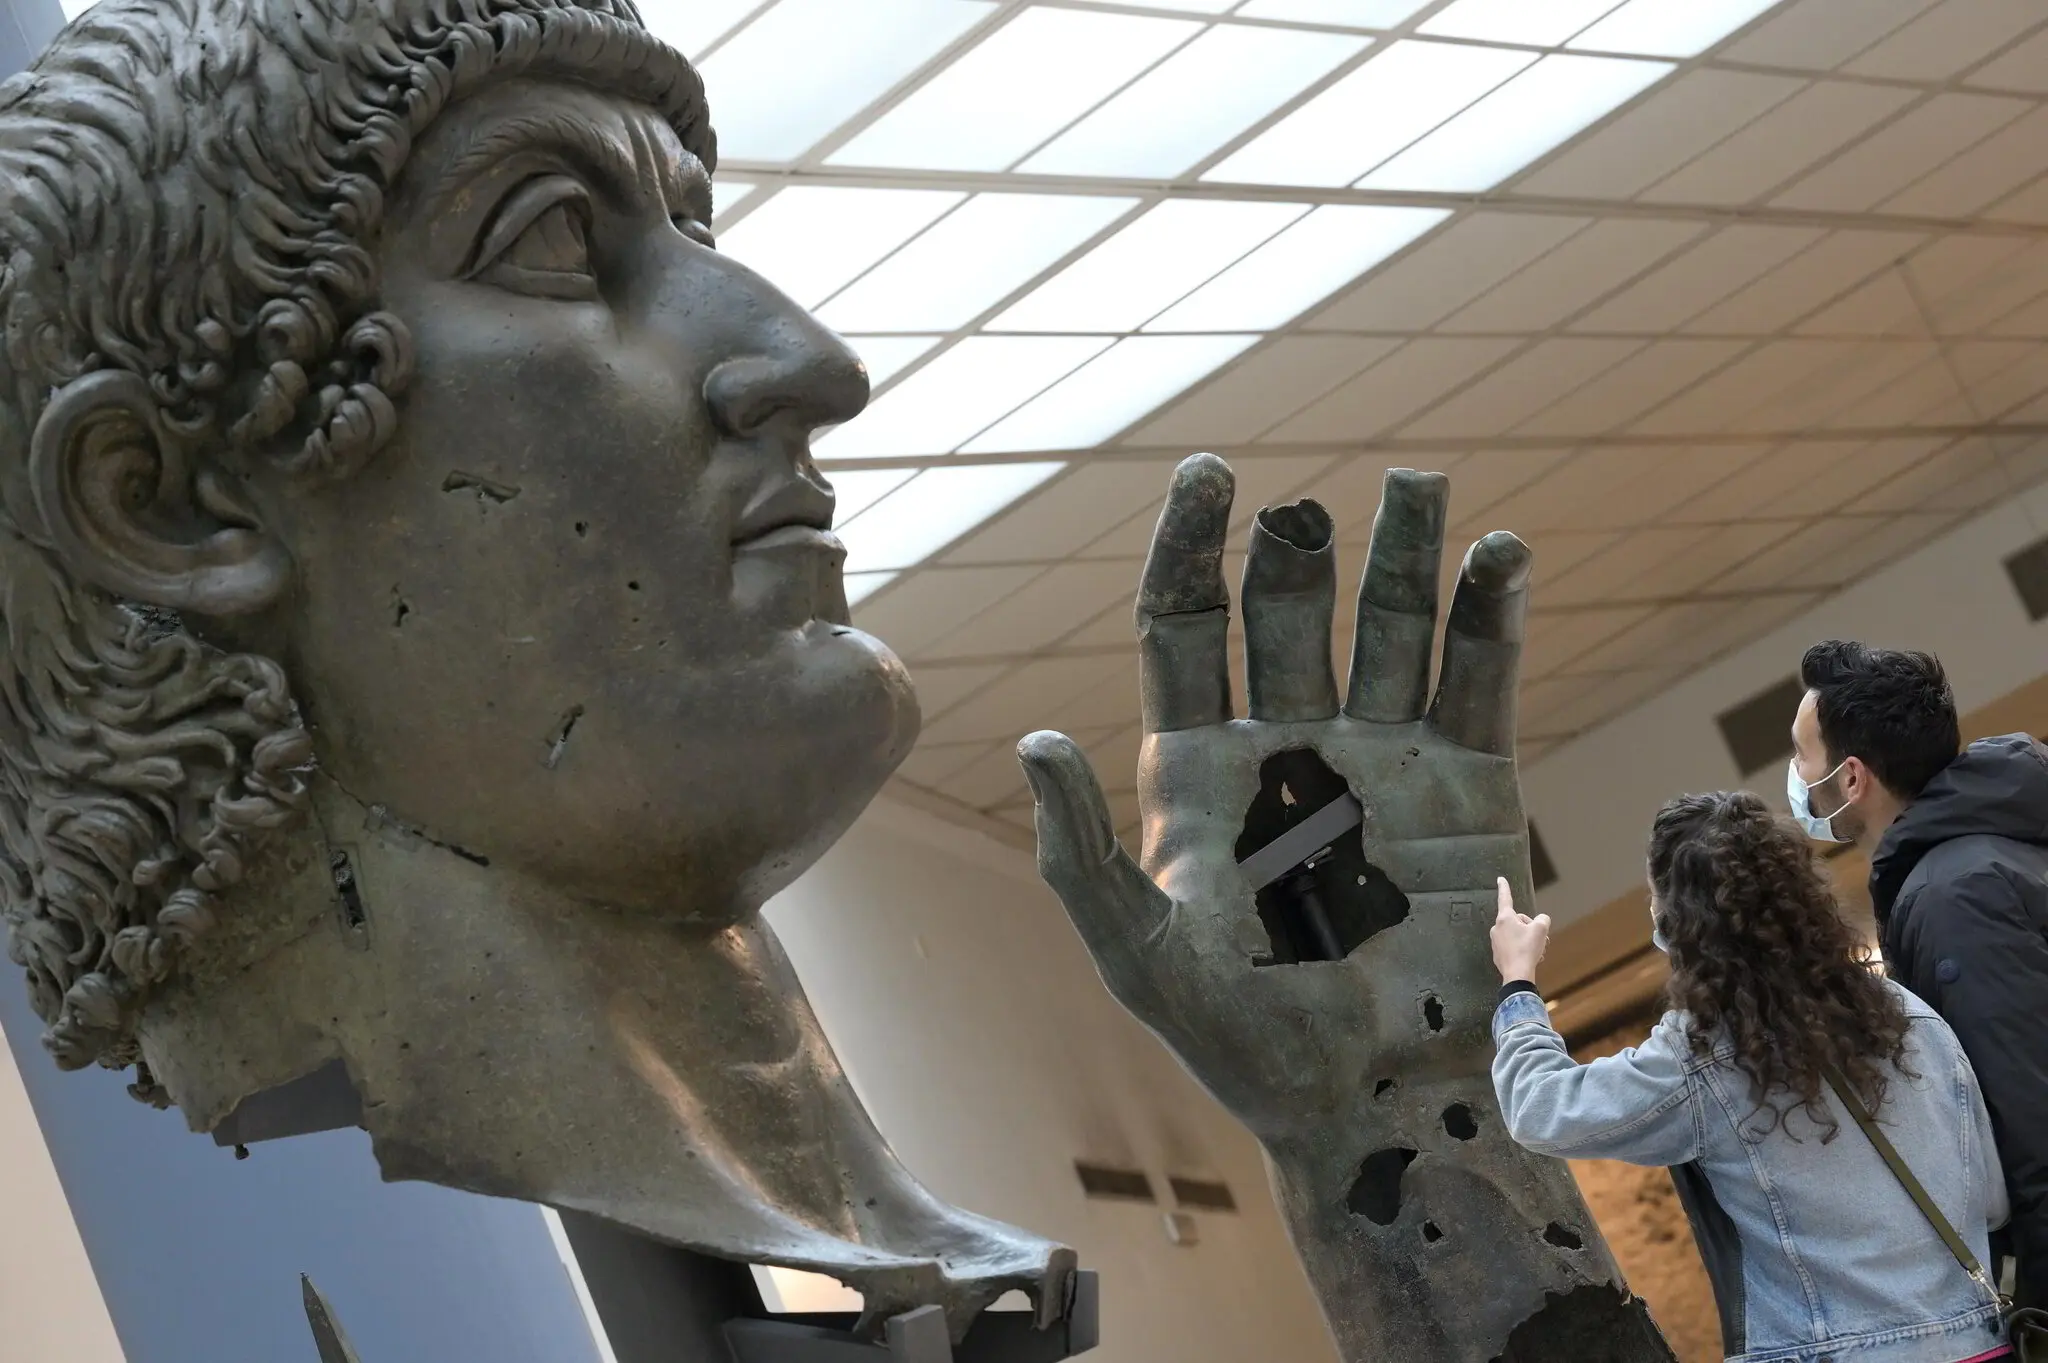

In [12]:
import base64
import mimetypes

def encode_image(image_path):
    mime_type, _ = mimetypes.guess_type(image_path)
    if not mime_type:
        raise ValueError("Could not determine MIME type")
    
    with open(image_path, "rb") as image_file:
        base64_data = base64.b64encode(image_file.read()).decode("utf-8")
    
    return f"data:{mime_type};base64,{base64_data}"
    
new = encode_image("/Users/shikhharsiingh/Downloads/merlin_187078398_58ba219b-7080-4b5a-a5ba-59f2254d3856-superJumbo.webp")
new

In [47]:
time.time() - 1739399138

1739319731.568156